https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a

https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

https://notebook.community/projectmesa/mesa-examples/examples/ForestFire/.ipynb_checkpoints/Forest%20Fire%20Model-checkpoint

To install Mesa, simply:

$ pip install mesa
https://mesa.readthedocs.io/en/latest/apis/space.html


The Forest Fire Model is one of the simplest examples of a model that exhibits self-organized criticality.

Mesa is a new, Pythonic agent-based modeling framework. A big advantage of using Python is that it a great language for interactive data analysis. Unlike some other ABM frameworks, with Mesa you can write a model, run it, and analyze it all in the same environment. (You don't have to, of course. But you can).

In this notebook, we'll go over a rapid-fire (pun intended, sorry) introduction to building and analyzing a model with Mesa.

First, some imports. We'll go over what all the Mesa ones mean just below.

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

Building the model
Most models consist of basically two things: agents, and an world for the agents to be in. The Forest Fire model has only one kind of agent: a tree. A tree can either be unburned, on fire, or already burned. The environment is a grid, where each cell can either be empty or contain a tree.

First, let's define our tree agent. The agent needs to be assigned x and y coordinates on the grid, and that's about it. We could assign agents a condition to be in, but for now let's have them all start as being 'Fine'. Since the agent doesn't move, and there is only at most one tree per cell, we can use a tuple of its coordinates as a unique identifier.

Next, we define the agent's step method. This gets called whenever the agent needs to act in the world and takes the model object to which it belongs as an input. The tree's behavior is simple: If it is currently on fire, it spreads the fire to any trees above, below, to the left and the right of it that are not themselves burned out or on fire; then it burns itself out.

In [2]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Building the model
Most models consist of basically two things: agents, and an world for the agents to be in. The Forest Fire model has only one kind of agent: a tree. A tree can either be unburned, on fire, or already burned. The environment is a grid, where each cell can either be empty or contain a tree.

First, let's define our tree agent. The agent needs to be assigned x and y coordinates on the grid, and that's about it. We could assign agents a condition to be in, but for now let's have them all start as being 'Fine'. Since the agent doesn't move, and there is only at most one tree per cell, we can use a tuple of its coordinates as a unique identifier.

Next, we define the agent's step method. This gets called whenever the agent needs to act in the world and takes the model object to which it belongs as an input. The tree's behavior is simple: If it is currently on fire, it spreads the fire to any trees above, below, to the left and the right of it that are not themselves burned out or on fire; then it burns itself out.

In [4]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

Running the model
Let's create a model with a 100 x 100 grid, and a tree density of 0.6. Remember, ForestFire takes the arguments height, width, density.

In [5]:
fire = ForestFire(100, 100, 0.6)

To run the model until it's done (that is, until it sets its running property to False) just use the run_model() method. This is implemented in the Model parent object, so we didn't need to implement it above.

In [6]:
fire.run_model()

That's all there is to it!

But... so what? This code doesn't include a visualization, after all.

TODO: Add a MatPlotLib visualization

Remember the data collector? Now we can put the data it collected into a pandas DataFrame:

In [7]:
results = fire.dc.get_model_vars_dataframe()

And chart it, to see the dynamics.

<AxesSubplot:>

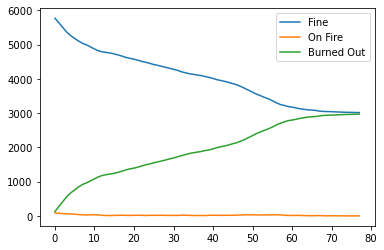

In [8]:
results.plot()

In this case, the fire burned itself out after about 90 steps, with many trees left unburned.

You can try changing the density parameter and rerunning the code above, to see how different densities yield different dynamics. For example:

<AxesSubplot:>

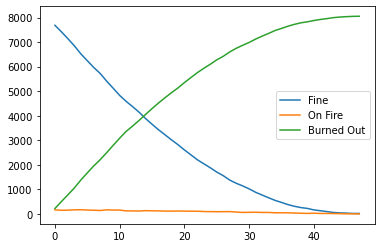

In [9]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()